# MPEG-G Microbiome Classification -  Centralized Solution

**(Private LB: 12th place)**

**Performance Achieved:**
- **Log Loss**: 0.0322 
- **Accuracy**: 0.9924 
- **F1-Score**: 0.9920 

**Pipeline:** ZIP extraction → MGB→ | K-mer → CLR transformation → XGBoost → Predictions

**Runtime Tracking:** All execution times are captured for each step

## 🐳 Prerequisites: Docker Setup

**IMPORTANT: This notebook runs on local Windows machines and requires Docker setup**

### System Requirements
- **Docker Desktop** for Windows
- **Minimum 8GB RAM** (16GB)

### 1. Install Docker Desktop for Windows
- Download from: https://docker.com/products/docker-desktop

### 2. Required Docker Images
The pipeline uses two specific Docker containers:
- **Genie**: MGB → FASTQ conversion (`muefab/genie:latest`)
- **Jellyfish**: K-mer counting (`quay.io/biocontainers/kmer-jellyfish:2.3.1--py310h184ae93_5`)

**⚡ First-time setup:** Image pulls may take 5-15 minutes (total ~2GB)

In [8]:
# Pull Required Docker Images (First-time setup only)
print("🐳 Pulling required Docker images...")

# Pull Genie image for MGB→FASTQ conversion
!docker pull muefab/genie:latest

# Pull Jellyfish image for k-mer counting  
!docker pull quay.io/biocontainers/kmer-jellyfish:2.3.1--py310h184ae93_5

print("✅ Docker images ready!")

🐳 Pulling required Docker images...
latest: Pulling from muefab/genie
Digest: sha256:c3112a3879cc18061bbab5ed8f76dec255ab1be46e2133cd59320dd5ba98ef89
Status: Image is up to date for muefab/genie:latest
docker.io/muefab/genie:latest
2.3.1--py310h184ae93_5: Pulling from biocontainers/kmer-jellyfish
Digest: sha256:340840b840cd82bd6257bcdbc8c59cac73d53a86d25f68258f48b585112be270
Status: Image is up to date for quay.io/biocontainers/kmer-jellyfish:2.3.1--py310h184ae93_5
quay.io/biocontainers/kmer-jellyfish:2.3.1--py310h184ae93_5
✅ Docker images ready!


In [9]:
# Verify Docker images are working
print("🧪 Testing Docker images...")

# Test Genie
!docker run --rm muefab/genie:latest help

# Test Jellyfish  
!docker run --rm quay.io/biocontainers/kmer-jellyfish:2.3.1--py310h184ae93_5 jellyfish --version

print("🚀 Docker setup complete!")

🧪 Testing Docker images...
[INFO,      0.000s, App]:    ______           _
[INFO,      0.000s, App]:   / ____/__  ____  (_)__
[INFO,      0.000s, App]:  / / __/ _ \/ __ \/ / _ \
[INFO,      0.000s, App]: / /_/ /  __/ / / / /  __/
[INFO,      0.001s, App]: \____/\___/_/ /_/_/\___/
[INFO,      0.001s, App]: Command: /usr/local/bin/genie help 
[ERROR,      0.005s, App]: Usage: 
[ERROR,      0.005s, App]: genie <operation> <operation specific options> 
[ERROR,      0.005s, App]: 
[ERROR,      0.005s, App]: List of operations:
[ERROR,      0.005s, App]: help
[ERROR,      0.005s, App]: run
[ERROR,      0.005s, App]: transcode-fastq
[ERROR,      0.005s, App]: transcode-sam
[ERROR,      0.005s, App]: 
[ERROR,      0.005s, App]: To learn more about an operation, type "genie <operation> --help".
jellyfish 2.3.1
🚀 Docker setup complete!


## 1. Setup and Configuration

In [15]:
# Core libraries
import os
import subprocess
import pandas as pd
import numpy as np
import zipfile
import json
import time
import warnings
from pathlib import Path
from collections import defaultdict
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
import xgboost as xgb
from scipy.stats import gmean


print("All libraries imported successfully!")
print(f"CPU cores detected: {os.cpu_count()}")

# Initialize runtime 
runtime_log = {}
start_time_total = time.time()

print(f"Pipeline started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
CPU cores detected: 8
Pipeline started at: 2025-09-21 13:32:32


In [16]:
# CONFIGURATION - Exact settings from winning solution
# =====================================================

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# K-mer extraction settings
KMER_SIZE = 8 # Size of k-mers to extract, coud be change to 6, 7, 9, or 10 to explore
MIN_KMER_COUNT = 3 # Minimum count to consider a k-mer, helps filter noise
BATCH_SIZE = 10 # Number of samples to process in parallel batches
JELLYFISH_HASH_SIZE = "50M" # Jellyfish hash size (memory allocation)
JELLYFISH_THREADS = 2

# Docker images (exact versions used)
GENIE_IMAGE = "muefab/genie:latest"
JELLYFISH_IMAGE = "quay.io/biocontainers/kmer-jellyfish:2.3.1--py310h184ae93_5"

# Directory structure
TRAIN_MGB_DIR = Path("TrainFiles")
TEST_MGB_DIR = Path("TestFiles")
TRAIN_OUTPUT_DIR = Path("kmer_train")
TEST_OUTPUT_DIR = Path("kmer_test")

# ML settings
CV_FOLDS = 5 # Number of cross-validation folds
MAX_FEATURES = 2000 # Max k-mer features to select with SelectKBest mutual_info_classif
N_JOBS = -1 # Use all available CPU cores

# Create output directories
TRAIN_OUTPUT_DIR.mkdir(exist_ok=True)
TEST_OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Configuration set:")
print(f"  K-mer size: {KMER_SIZE}")
print(f"  Min count: {MIN_KMER_COUNT}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Random state: {RANDOM_STATE}")
print(f"  Output dirs created: {TRAIN_OUTPUT_DIR}, {TEST_OUTPUT_DIR}")

Configuration set:
  K-mer size: 8
  Min count: 3
  Batch size: 10
  Random state: 42
  Output dirs created: kmer_train, kmer_test


## 2. Utility Functions

In [17]:
def log_runtime(step_name, start_time): # Log runtime for a step
    """Log runtime for a step"""
    elapsed = time.time() - start_time
    runtime_log[step_name] = elapsed
    print(f"⏱️  {step_name}: {elapsed:.2f}s")
    return elapsed

def extract_zip_file(zip_path, extract_to, skip_existing=True):  # Extract ZIP file containing MGB files, chk for existing files
    """
    Extract ZIP file containing MGB files.
    """
    zip_file = Path(zip_path)
    extract_path = Path(extract_to)

    if not zip_file.exists():
        print(f"ZIP file not found: {zip_path}")
        return False

    # Check for existing files
    if skip_existing and extract_path.exists():
        existing_files = list(extract_path.glob("*.mgb"))
        if existing_files:
              print(f"Directory {extract_to} already contains {len(existing_files)} MGB files - skipping extraction")
              return True

    print(f"Extracting {zip_path} to {extract_to}...")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
              # Create extraction directory
              extract_path.mkdir(exist_ok=True)

              # Extract all files directly to target directory
              zip_ref.extractall(extract_path)

              # Count extracted MGB files
              mgb_files = list(extract_path.glob("*.mgb"))
              print(f"Successfully extracted {len(mgb_files)} MGB files")

              return True

    except Exception as e:
        print(f"Error extracting {zip_path}: {str(e)}")
    return False

def clr_transform(data, pseudocount=1e-6):  # Apply Centered Log-Ratio transformation on k-mer count data
    """Apply Centered Log-Ratio transformation to compositional data"""
    # Add pseudocount to avoid log(0)
    data_pseudo = data + pseudocount
    # Calculate geometric mean for each sample
    geom_means = gmean(data_pseudo, axis=1)
    # Apply CLR transformation
    clr_data = np.log(data_pseudo / geom_means[:, np.newaxis])
    return clr_data

print("Utility functions defined!")

Utility functions defined!


## 3. Streaming MGB → K-mer Pipeline Functions

In [ ]:
def stream_mgb_to_kmers(mgb_file_path, temp_dir): # Stream MGB → Genie → Jellyfish → K-mer counts
    """
    Stream MGB → Genie → Jellyfish → K-mer counts
    No intermediate FASTQ files saved to disk
    """
    mgb_path = Path(mgb_file_path)
    sample_id = mgb_path.stem
    temp_dir = Path(temp_dir)
    temp_dir.mkdir(exist_ok=True)

    try:
        # Temporary files
        temp_fastq = temp_dir / f"{sample_id}_temp.fastq"
        temp_jf = temp_dir / f"{sample_id}_temp.jf"

        # Docker setup
        work_root = Path.cwd()
        docker_mount = f"{work_root}:/work"

        def to_docker_path(local_path):
            abs_path = Path(local_path).resolve()
            rel_path = abs_path.relative_to(work_root)
            return "/work/" + str(rel_path).replace('\\', '/')

        # Step 1: MGB → FASTQ via Genie
        genie_cmd = [
            "docker", "run", "--rm", "-v", docker_mount,
            GENIE_IMAGE, "run", "-i", to_docker_path(mgb_path),
            "-o", to_docker_path(temp_fastq), "-f"
        ]

        result = subprocess.run(genie_cmd, capture_output=True, text=True)
        if result.returncode != 0:
            raise Exception(f"Genie failed: {result.stderr}")

        # Step 2: FASTQ → K-mer counts via Jellyfish
        jellyfish_count_cmd = [
            "docker", "run", "--rm", "-v", docker_mount,
            JELLYFISH_IMAGE, "jellyfish", "count",
            "-m", str(KMER_SIZE), "-s", JELLYFISH_HASH_SIZE,
            "-t", str(JELLYFISH_THREADS), "-L", str(MIN_KMER_COUNT), "-C",
            "-o", to_docker_path(temp_jf), to_docker_path(temp_fastq)
        ]

        result = subprocess.run(jellyfish_count_cmd, capture_output=True, text=True)
        if result.returncode != 0:
            raise Exception(f"Jellyfish count failed: {result.stderr}")

        # Step 3: Extract k-mer counts
        jellyfish_dump_cmd = [
            "docker", "run", "--rm", "-v", docker_mount,
            JELLYFISH_IMAGE, "jellyfish", "dump", "-c", to_docker_path(temp_jf)
        ]

        result = subprocess.run(jellyfish_dump_cmd, capture_output=True, text=True)
        if result.returncode != 0:
            raise Exception(f"Jellyfish dump failed: {result.stderr}")

        # Parse k-mer counts
        kmer_counts = {}
        total_kmers = 0

        for line in result.stdout.strip().split('\n'):
            if not line.strip():
                continue
            parts = line.split()
            if len(parts) >= 2:
                try:
                    kmer, count = parts[0], int(parts[1])
                    kmer_counts[kmer] = count
                    total_kmers += count
                except:
                    continue

        unique_kmers = len(kmer_counts)

        # Cleanup temp files
        temp_fastq.unlink(missing_ok=True)
        temp_jf.unlink(missing_ok=True)

        return {
            'sample_id': sample_id,
            'total_kmers': total_kmers,
            'unique_kmers': unique_kmers,
            'kmer_counts': kmer_counts,
            'success': True
        }

    except Exception as e:
        # Cleanup on error
        temp_fastq.unlink(missing_ok=True)
        temp_jf.unlink(missing_ok=True)

        return {
            'sample_id': sample_id,
            'error': str(e),
            'success': False
        }

print("Streaming function defined!")

Streaming function defined!


In [ ]:
def save_result(result, output_dir, dataset_type="train"): # Save individual result to file to allow resuming of processing if interrupted
    """Save individual result to file"""
    results_dir = output_dir / "results"
    results_dir.mkdir(exist_ok=True)

    sample_id = result['sample_id']
    result_file = results_dir / f"{dataset_type}_{sample_id}.json"

    with open(result_file, 'w') as f:
        json.dump(result, f)

def load_processed_results(output_dir, dataset_type="train"): # Load individual result files to continue processing 
    """Load all processed results from individual result files"""
    results_dir = output_dir / "results"
    results_dir.mkdir(exist_ok=True)

    result_files = list(results_dir.glob(f"{dataset_type}_*.json"))
    all_results = []

    for result_file in result_files:
        with open(result_file, 'r') as f:
            result = json.load(f)
            all_results.append(result)

    return all_results

print("File handling functions defined!")

File handling functions defined!


In [ ]:
def process_samples_batch(mgb_files, output_dir, dataset_type="train"): # Batch process MGB files with checkpointing every 5 samples
    """
    Process a batch of MGB files and save intermediate results with checkpointing
    (batch processing with resumability)
    """
    step_start = time.time()
    print(f"Processing {len(mgb_files)} {dataset_type} samples...")

    # Load existing checkpoint if available
    checkpoint_file = output_dir / f"{dataset_type}_checkpoint.json"
    processed_samples = set()
    if checkpoint_file.exists():
        with open(checkpoint_file, 'r') as f:
            checkpoint_data = json.load(f)
            processed_samples = set(checkpoint_data.get('processed_samples', []))
            print(f"  📁 Loaded checkpoint: {len(processed_samples)} samples already processed")

    all_results = []
    temp_dir = output_dir / "temp"
    temp_dir.mkdir(exist_ok=True)

    # Filter out already processed files
    remaining_files = [f for f in mgb_files if Path(f).stem not in processed_samples]
    if not remaining_files:
        print(f"  ✅ All {len(mgb_files)} samples already processed!")
        log_runtime(f"{dataset_type}_batch_processing", step_start)
        return []

    print(f"  🔄 Processing {len(remaining_files)} next samples...")
    start_time = time.time()

    for i, mgb_file in enumerate(remaining_files, 1):
        sample_id = Path(mgb_file).stem
        print(f"  [{i}/{len(remaining_files)}] {sample_id}")

        sample_start = time.time()
        result = stream_mgb_to_kmers(mgb_file, temp_dir)
        sample_time = time.time() - sample_start
        
        all_results.append(result)

        if result['success']:
            print(f"    ✅ {result['unique_kmers']} k-mers, {result['total_kmers']:,} total ({sample_time:.1f}s)")
            processed_samples.add(sample_id)
            # Save individual result
            save_result(result, output_dir, dataset_type)
        else:
            print(f"    ❌ {result.get('error', 'Unknown error')} ({sample_time:.1f}s)")

        # Save checkpoint every 5 samples
        if i % 5 == 0 or i == len(remaining_files):
            checkpoint_data = {
                'processed_samples': list(processed_samples),
                'last_updated': time.time()
            }
            with open(checkpoint_file, 'w') as f:
                json.dump(checkpoint_data, f)
            print(f"    💾 Checkpoint saved ({len(processed_samples)} total)")

    elapsed = log_runtime(f"{dataset_type}_batch_processing", step_start)
    successful = sum(1 for r in all_results if r['success'])

    print(f"Batch complete: {successful}/{len(all_results)} successful ({elapsed:.1f}s)")
    return all_results

print("Batch processing function defined!")

Batch processing function defined!


In [ ]:
def create_matrices(all_results, output_dir, dataset_type="train"):  # Create train_kmercount.csv or test_kmercount.csv 
    """Create train_kmercount.csv or test_kmercount.csv from results """
    step_start = time.time()
    print(f"Creating matrices for {dataset_type} data...")

    # If no new results, try loading from saved results
    if not all_results:
        print("  No new results - loading from saved files...")
        all_results = load_processed_results(output_dir, dataset_type)

    successful_results = [r for r in all_results if r.get('success', False)]
    print(f"  Successful samples: {len(successful_results)}")

    if not successful_results:
        print("  No successful results to process!")
        return

    # Get all unique k-mers
    all_kmers = set()
    for result in successful_results:
        if 'kmer_counts' in result:
            all_kmers.update(result['kmer_counts'].keys())

    all_kmers = sorted(list(all_kmers))
    print(f"  Total unique k-mers: {len(all_kmers):,}")

    if not all_kmers:
        print("  No k-mers found!")
        return

    # Create count matrix (raw counts) - THIS IS WHAT will be used for ML and used by XBoost and Federated Learning 
    count_data = []
    for result in successful_results:
        sample_id = result['sample_id']
        kmer_counts = result.get('kmer_counts', {})

        row = {'filename': sample_id}
        row.update({kmer: kmer_counts.get(kmer, 0) for kmer in all_kmers})
        count_data.append(row)

    count_df = pd.DataFrame(count_data)
    count_file = output_dir / f"{dataset_type}_kmercount.csv"
    count_df.to_csv(count_file, index=False)
    
    elapsed = log_runtime(f"{dataset_type}_matrix_creation", step_start)
    print(f"  ✅ Count matrix saved: {count_file} ({count_df.shape}) - {elapsed:.1f}s")

    return count_df

print("Matrix creation function defined!")

Matrix creation function defined!


## 4. Extract ZIP Files

In [19]:
step_start = time.time()
print("🗂️  STEP 1: EXTRACTING ZIP FILES")
print("-" * 40)

# Extract TrainFiles.zip
train_extracted = extract_zip_file("TrainFiles.zip", TRAIN_MGB_DIR, skip_existing=True)

# Extract TestFiles.zip
test_extracted = extract_zip_file("TestFiles.zip", TEST_MGB_DIR, skip_existing=True)

if not (train_extracted and test_extracted):
    raise Exception("❌ Error: ZIP extraction failed - check file paths")

# Count extracted files
train_mgb_count = len(list(TRAIN_MGB_DIR.glob("*.mgb")))
test_mgb_count = len(list(TEST_MGB_DIR.glob("*.mgb")))

# Log the runtime and emissions for this step
log_runtime("zip_extraction", step_start)

print(f"✅ ZIP extraction completed!")
print(f"   Training MGB files: {train_mgb_count}")
print(f"   Test MGB files: {test_mgb_count}")

🗂️  STEP 1: EXTRACTING ZIP FILES
----------------------------------------
Directory TrainFiles already contains 2901 MGB files - skipping extraction
Directory TestFiles already contains 1068 MGB files - skipping extraction
⏱️  zip_extraction: 0.05s
✅ ZIP extraction completed!
   Training MGB files: 2901
   Test MGB files: 1068


## 5. Process Training Data

In [20]:
step_start = time.time()
print("🧬 STEP 2: PROCESSING TRAINING DATA")
print("-" * 40)

# Get training MGB files
train_mgb_files = list(TRAIN_MGB_DIR.glob("*.mgb"))

# Check for existing output files (resumability)
train_count_file = TRAIN_OUTPUT_DIR / "train_kmercount.csv"

if train_count_file.exists():
    print("✅ Training files already exist - skipping processing")
    train_counts = pd.read_csv(train_count_file)
    print(f"   Loaded: {train_counts.shape[0]} samples, {train_counts.shape[1]-1} k-mers")
    log_runtime("training_data_processing", step_start)
else:
    print("🔄 Processing training samples...")

    # Process in batches
    all_train_results = []

    # Split into batches
    batches = [train_mgb_files[i:i + BATCH_SIZE] for i in range(0, len(train_mgb_files), BATCH_SIZE)]
    print(f"Processing {len(batches)} batches of up to {BATCH_SIZE} samples")

    batch_times = []
    for batch_idx, batch_files in enumerate(batches, 1):
        print(f"\n--- Batch {batch_idx}/{len(batches)} ---")
        batch_start = time.time()
        batch_results = process_samples_batch(batch_files, TRAIN_OUTPUT_DIR, "train")
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        all_train_results.extend(batch_results)
        
        print(f"   Batch {batch_idx} completed in {batch_time:.1f}s")

        # Brief pause between batches
        if batch_idx < len(batches):
            time.sleep(1)

    # Create final matrices
    print(f"\n📊 Creating final matrices...")
    train_counts = create_matrices(all_train_results, TRAIN_OUTPUT_DIR, "train")
    
    total_batch_time = sum(batch_times)
    print(f"   Total batch processing time: {total_batch_time:.1f}s")
    print(f"   Average per batch: {total_batch_time/len(batch_times):.1f}s")
    
    log_runtime("training_data_processing", step_start)

print("\n✅ Training data processing complete!")

🧬 STEP 2: PROCESSING TRAINING DATA
----------------------------------------
✅ Training files already exist - skipping processing
   Loaded: 2901 samples, 32896 k-mers
⏱️  training_data_processing: 55.94s

✅ Training data processing complete!


## 6. Process Test Data

In [21]:
step_start = time.time()
print("🧪 STEP 3: PROCESSING TEST DATA")
print("-" * 40)

# Get test MGB files
test_mgb_files = list(TEST_MGB_DIR.glob("*.mgb"))

# Check for existing output files (resumability)
test_count_file = TEST_OUTPUT_DIR / "test_kmercount.csv"

if test_count_file.exists():
    print("✅ Test files already exist - skipping processing")
    test_counts = pd.read_csv(test_count_file)
    print(f"   Loaded: {test_counts.shape[0]} samples, {test_counts.shape[1]-1} k-mers")
    log_runtime("test_data_processing", step_start)
else:
    print("🔄 Processing test samples...")

    # Process in batches
    all_test_results = []

    # Split into batches
    batches = [test_mgb_files[i:i + BATCH_SIZE] for i in range(0, len(test_mgb_files), BATCH_SIZE)]
    print(f"Processing {len(batches)} batches of up to {BATCH_SIZE} samples")

    batch_times = []
    for batch_idx, batch_files in enumerate(batches, 1):
        print(f"\n--- Batch {batch_idx}/{len(batches)} ---")
        batch_start = time.time()
        batch_results = process_samples_batch(batch_files, TEST_OUTPUT_DIR, "test")
        batch_time = time.time() - batch_start
        batch_times.append(batch_time)
        all_test_results.extend(batch_results)
        
        print(f"   Batch {batch_idx} completed in {batch_time:.1f}s")

        # Brief pause between batches
        if batch_idx < len(batches):
            time.sleep(1)

    # Create final matrices
    print(f"\n📊 Creating final matrices...")
    test_counts = create_matrices(all_test_results, TEST_OUTPUT_DIR, "test")
    
    total_batch_time = sum(batch_times)
    print(f"   Total batch processing time: {total_batch_time:.1f}s")
    print(f"   Average per batch: {total_batch_time/len(batch_times):.1f}s")
    
    log_runtime("test_data_processing", step_start)

print("\n✅ Test data processing complete!")

🧪 STEP 3: PROCESSING TEST DATA
----------------------------------------
✅ Test files already exist - skipping processing
   Loaded: 1068 samples, 32896 k-mers
⏱️  test_data_processing: 20.03s

✅ Test data processing complete!


## 7. Machine Learning Pipeline

In [18]:
step_start = time.time()
print("🤖 STEP 4: MACHINE LEARNING PIPELINE")
print("-" * 40)

# Load data
kmercount_df = pd.read_csv(TRAIN_OUTPUT_DIR / "train_kmercount.csv")
train_labels_df = pd.read_csv("Train.csv")

print(f"K-mer counts: {kmercount_df.shape}")
print(f"Train labels: {train_labels_df.shape}")

# Fix filename mismatch - remove .mgb extension from Train.csv
train_labels_df['filename'] = train_labels_df['filename'].str.replace('.mgb', '')

# Merge k-mer counts with sample types
train_features_df = kmercount_df.merge(train_labels_df, on='filename', how='inner')
print(f"Merged data: {train_features_df.shape}")

filename_col = 'filename'
sample_type_col = 'SampleType'

print("Sample distribution:", train_features_df[sample_type_col].value_counts().to_dict())

log_runtime("data_loading_ml", step_start)

🤖 STEP 4: MACHINE LEARNING PIPELINE
----------------------------------------
K-mer counts: (2901, 32897)
Train labels: (2901, 4)
Merged data: (2901, 32900)
Sample distribution: {'Stool': 811, 'Skin': 787, 'Nasal': 710, 'Mouth': 593}
⏱️  data_loading_ml: 59.81s


59.806758880615234

In [19]:
# Feature engineering
step_start = time.time()

feature_columns = [col for col in train_features_df.columns
                  if col not in [filename_col, sample_type_col, 'SubjectID', 'SampleID']]

X_full = train_features_df[feature_columns].fillna(0)

# Apply CLR transformation
print("🔬 Applying CLR transformation...")
clr_start = time.time()
X_clr = clr_transform(X_full.values)
X_full = pd.DataFrame(X_clr, columns=feature_columns, index=X_full.index)
X_full = X_full.replace([np.inf, -np.inf], np.nan).fillna(0)
clr_time = time.time() - clr_start
print(f"   CLR transformation completed in {clr_time:.2f}s")

y = train_features_df[sample_type_col]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print(f"Features: {X_full.shape}")
print(f"Classes: {list(class_names)}")

# Feature selection
print("📈 Feature selection...")
fs_start = time.time()
non_zero_var_features = X_full.var() > 0
X_filtered = X_full.loc[:, non_zero_var_features]

n_features_to_select = min(MAX_FEATURES, X_filtered.shape[1])
selector = SelectKBest(score_func=mutual_info_classif, k=n_features_to_select)
X_selected = selector.fit_transform(X_filtered, y_encoded)
fs_time = time.time() - fs_start
print(f"   Feature selection completed in {fs_time:.2f}s")

print(f"Selected features: {X_selected.shape}")

log_runtime("feature_engineering", step_start)

🔬 Applying CLR transformation...
   CLR transformation completed in 8.12s
Features: (2901, 32896)
Classes: ['Mouth', 'Nasal', 'Skin', 'Stool']
📈 Feature selection...
   Feature selection completed in 519.80s
Selected features: (2901, 2000)
⏱️  feature_engineering: 528.78s


528.7767317295074

In [20]:
# XGBoost training and cross-validation 
step_start = time.time()
print("🚀 XGBoost Training and Cross-Validation...")

# Direct XGBoost model 
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
scoring = ['neg_log_loss', 'accuracy', 'f1_macro']

print("Running cross-validation...")
cv_start = time.time()

cv_scores = cross_validate(
    xgb_model, X_selected, y_encoded, cv=skf, scoring=scoring,
    return_train_score=True, n_jobs=N_JOBS
)

cv_time = time.time() - cv_start

results = {
    'log_loss_mean': -cv_scores['test_neg_log_loss'].mean(),
    'log_loss_std': cv_scores['test_neg_log_loss'].std(),
    'accuracy_mean': cv_scores['test_accuracy'].mean(),
    'accuracy_std': cv_scores['test_accuracy'].std(),
    'f1_mean': cv_scores['test_f1_macro'].mean(),
    'f1_std': cv_scores['test_f1_macro'].std(),
    'cv_time': cv_time
}

print(f"✅ Cross-validation results:")
print(f"   Log Loss: {results['log_loss_mean']:.4f} ± {results['log_loss_std']:.4f}")
print(f"   Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
print(f"   F1-Score: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
print(f"   CV Time: {cv_time:.1f}s")

# Train final model
final_train_start = time.time()
final_model = xgb_model.fit(X_selected, y_encoded)
final_train_time = time.time() - final_train_start
print(f"✅ Final model trained in {final_train_time:.1f}s")

log_runtime("xgboost_training", step_start)

🚀 XGBoost Training and Cross-Validation...
Running cross-validation...
✅ Cross-validation results:
   Log Loss: 0.0322 ± 0.0206
   Accuracy: 0.9924 ± 0.0048
   F1-Score: 0.9920 ± 0.0050
   CV Time: 109.5s
✅ Final model trained in 43.8s
⏱️  xgboost_training: 153.29s


153.2851402759552

## 8. Test Data processing prediction

In [ ]:
step_start = time.time()
print("🎯 STEP 5: TEST DATA PROCESSING & PREDICTIONS")
print("-" * 40)

# Load test data
test_kmercount_df = pd.read_csv(TEST_OUTPUT_DIR / "test_kmercount.csv")
print(f"Test k-mer counts: {test_kmercount_df.shape}")

# Apply SAME feature engineering as training data
test_filename_col = 'filename'
test_feature_cols = [col for col in test_kmercount_df.columns if col != test_filename_col]

# Create test feature matrix with same columns as training
X_test_full = pd.DataFrame(0.0, index=test_kmercount_df.index, columns=feature_columns)

# Fill with common features
common_features = set(feature_columns) & set(test_feature_cols)
for feature in common_features:
    X_test_full[feature] = test_kmercount_df[feature].fillna(0)

print(f"Test features aligned: {len(common_features)} common features")

# Apply CLR transformation to test data (SAME AS TRAINING)
print("🔬 Applying CLR transformation to test data...")
test_clr_start = time.time()
X_test_clr = clr_transform(X_test_full.values)
X_test_full = pd.DataFrame(X_test_clr, columns=feature_columns, index=X_test_full.index)
X_test_full = X_test_full.replace([np.inf, -np.inf], np.nan).fillna(0)
test_clr_time = time.time() - test_clr_start
print(f"   Test CLR transformation completed in {test_clr_time:.2f}s")

# Apply SAME feature selection as training
X_test_filtered = X_test_full.loc[:, non_zero_var_features]
X_test_selected = selector.transform(X_test_filtered)

print(f"Test data after feature engineering: {X_test_selected.shape}")

# Generate predictions
print("🎯 Generating predictions...")
pred_start = time.time()
test_predictions = final_model.predict_proba(X_test_selected)
pred_time = time.time() - pred_start
print(f"   Predictions generated in {pred_time:.2f}s")

# Create submission file
print("📄 Creating submission file...")
submission_df = pd.DataFrame({
    'filename': test_kmercount_df[test_filename_col]
})

# Add probability columns for each class
for i, class_name in enumerate(class_names):
    submission_df[class_name] = test_predictions[:, i]

# Save submission file
log_loss = results['log_loss_mean']
output_file = f"submission_notebook_logloss{log_loss:.4f}.csv"
submission_df.to_csv(output_file, index=False)

log_runtime("prediction_generation", step_start)
print(f"✅ Submission saved: {output_file}")
print("First 5 predictions:")
print(submission_df.head())

print(f"\n📊 Prediction Statistics:")
print(f"   Total test samples: {len(test_predictions)}")
print(f"   Prediction shape: {test_predictions.shape}")
print(f"   Class names: {list(class_names)}")


🎯 STEP 5: TEST DATA PROCESSING & PREDICTIONS
----------------------------------------
Test k-mer counts: (1068, 32897)
Test features aligned: 32896 common features
🔬 Applying CLR transformation to test data...
   Test CLR transformation completed in 2.85s
Test data after feature engineering: (1068, 2000)
🎯 Generating predictions...
   Predictions generated in 0.03s
📄 Creating submission file...
⏱️  prediction_generation: 191.06s
🌱 prediction_generation emissions: 0.000206 kg CO2
✅ Submission saved: submission_notebook_logloss0.0322.csv
First 5 predictions:
    filename     Mouth     Nasal      Skin     Stool
0  ID_ABHFUP  0.000124  0.999599  0.000147  0.000130
1  ID_ADBLNY  0.000124  0.999614  0.000132  0.000130
2  ID_AFAEMB  0.999492  0.000131  0.000249  0.000127
3  ID_AFBBWK  0.999573  0.000116  0.000199  0.000112
4  ID_AGHEZK  0.999359  0.000199  0.000300  0.000142
\n📊 Prediction Statistics:
   Total test samples: 1068
   Prediction shape: (1068, 4)
   Class names: ['Mouth', 'Nasal'

## 9. Final Results and Runtime Summary

In [ ]:
total_time = time.time() - start_time_total
runtime_log['total_pipeline'] = total_time

print("\n" + "=" * 60)
print("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 60)

print(f"📊 Final Results:")
print(f"   Log Loss: {results['log_loss_mean']:.4f} ± {results['log_loss_std']:.4f}")
print(f"   Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
print(f"   F1-Score: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")

print(f"\n⏱️  Detailed Runtime Summary:")
print(f"   {'Step':<30} {'Time (s)':<12} {'Time (min)':<12}")
print("-" * 54)

for step, runtime in runtime_log.items():
    print(f"   {step:<30} {runtime:<12.1f} {runtime/60:<12.1f}")

print(f"\n📁 Output files:")
print(f"   Training k-mers: {TRAIN_OUTPUT_DIR}/train_kmercount.csv")
print(f"   Test k-mers: {TEST_OUTPUT_DIR}/test_kmercount.csv")
print(f"   Submission: {output_file}")


print(f"\n🕒 Total pipeline runtime: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"📅 Completed at: {time.strftime('%Y-%m-%d %H:%M:%S')}")


🌱 total_pipeline emissions: 0.105996 kg CO2

🎉 PIPELINE COMPLETED SUCCESSFULLY!
📊 Final Results:
   Log Loss: 0.0322 ± 0.0206
   Accuracy: 0.9924 ± 0.0048
   F1-Score: 0.9920 ± 0.0050

⏱️  Detailed Runtime Summary:
   Step                           Time (s)     Time (min)  
------------------------------------------------------
   zip_extraction                 141.4        2.4         
   train_batch_processing         14.9         0.2         
   train_matrix_creation          265.3        4.4         
   training_data_processing       69549.6      1159.2      
   test_batch_processing          110.4        1.8         
   test_matrix_creation           64.8         1.1         
   test_data_processing           20626.5      343.8       
   data_loading_ml                53.2         0.9         
   feature_engineering            469.7        7.8         
   xgboost_training               162.2        2.7         
   visualization_class_distribution 4.0          0.1         
   visua

## 🔎 Key Visualizations for Microbiome K-mer Analysis

These visualizations provide insights into the microbiome classification pipeline and model performance.

In [28]:
# Required visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

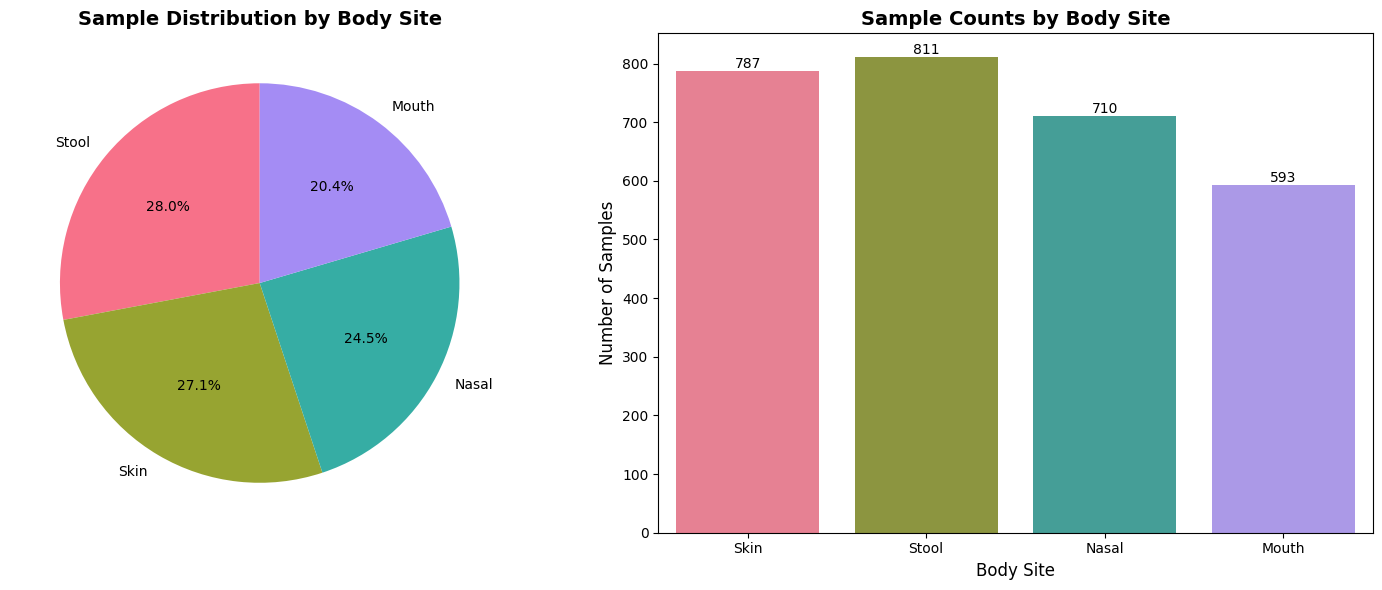

📊 Sample Distribution:
   Stool: 811 samples (28.0%)
   Skin: 787 samples (27.1%)
   Nasal: 710 samples (24.5%)
   Mouth: 593 samples (20.4%)


In [29]:
# 1. Sample Distribution and Class Balance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Class distribution
class_counts = train_features_df[sample_type_col].value_counts()
colors = sns.color_palette("husl", len(class_counts))

ax1.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Sample Distribution by Body Site', fontsize=14, fontweight='bold')

# Bar plot with counts
sns.countplot(data=train_features_df, x=sample_type_col, ax=ax2, palette="husl")
ax2.set_title('Sample Counts by Body Site', fontsize=14, fontweight='bold')
ax2.set_xlabel('Body Site', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)

# Add count labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fontsize=10)

plt.tight_layout()
plt.savefig('microbiome_sample_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Sample Distribution:")
for site, count in class_counts.items():
    print(f"   {site}: {count} samples ({count/len(train_features_df)*100:.1f}%)")

🔬 Computing PCA...
🔬 Computing t-SNE...


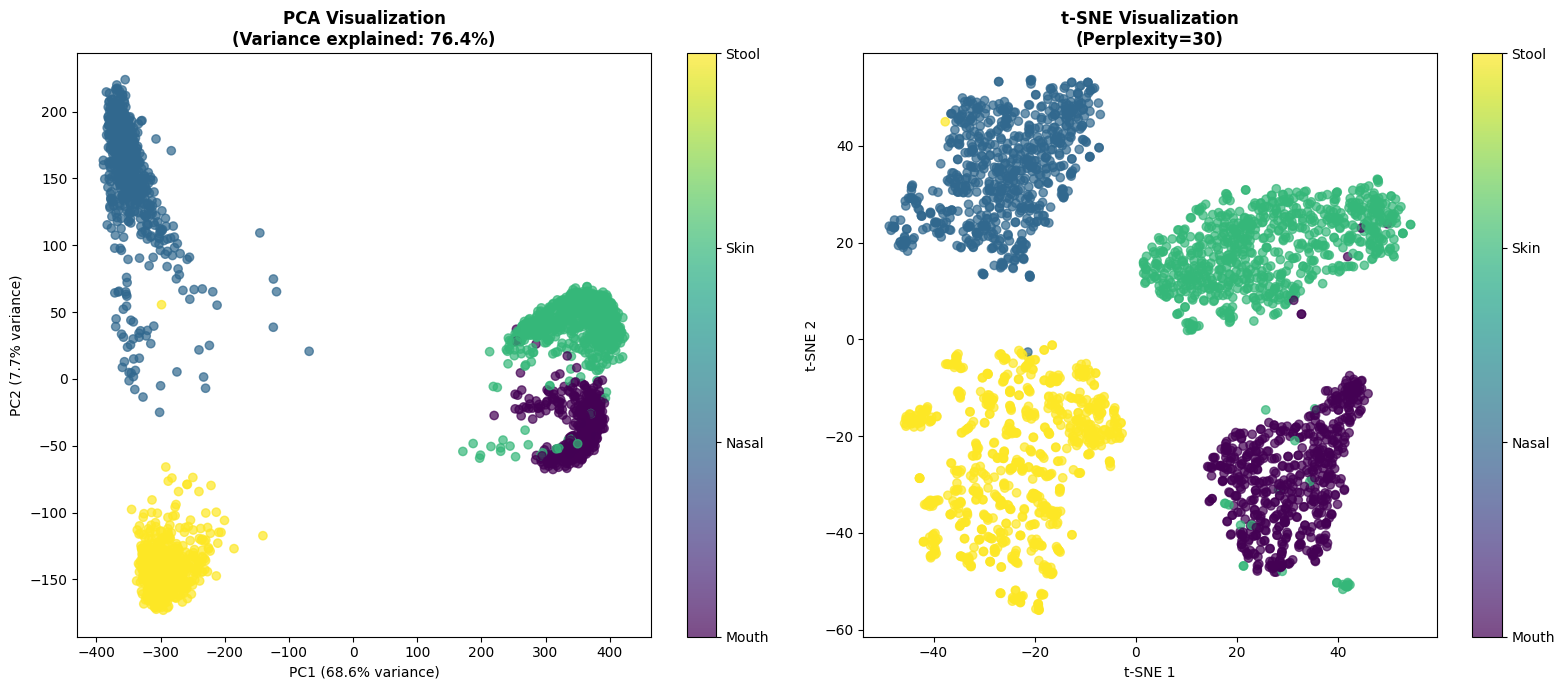

📊 Dimensionality Reduction Results:
   PCA explained variance: 76.4%
   Original dimensions: 2,000
   Reduced dimensions: 2


In [33]:
# 3. Dimensionality Reduction: PCA and t-SNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# PCA
print("🔬 Computing PCA...")
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_selected)

scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
ax1.set_title(f'PCA Visualization\n(Variance explained: {pca.explained_variance_ratio_.sum():.1%})', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

# Add colorbar for PCA
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_ticks(range(len(class_names)))
cbar1.set_ticklabels(class_names)

# t-SNE
print("🔬 Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_selected)

scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
ax2.set_title('t-SNE Visualization\n(Perplexity=30)', fontsize=12, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

# Add colorbar for t-SNE
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_ticks(range(len(class_names)))
cbar2.set_ticklabels(class_names)

plt.tight_layout()
plt.savefig('microbiome_dimensionality_reduction.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Dimensionality Reduction Results:")
print(f"   PCA explained variance: {pca.explained_variance_ratio_.sum():.1%}")
print(f"   Original dimensions: {X_selected.shape[1]:,}")
print(f"   Reduced dimensions: 2")

🎯 Generating cross-validation predictions for detailed analysis...


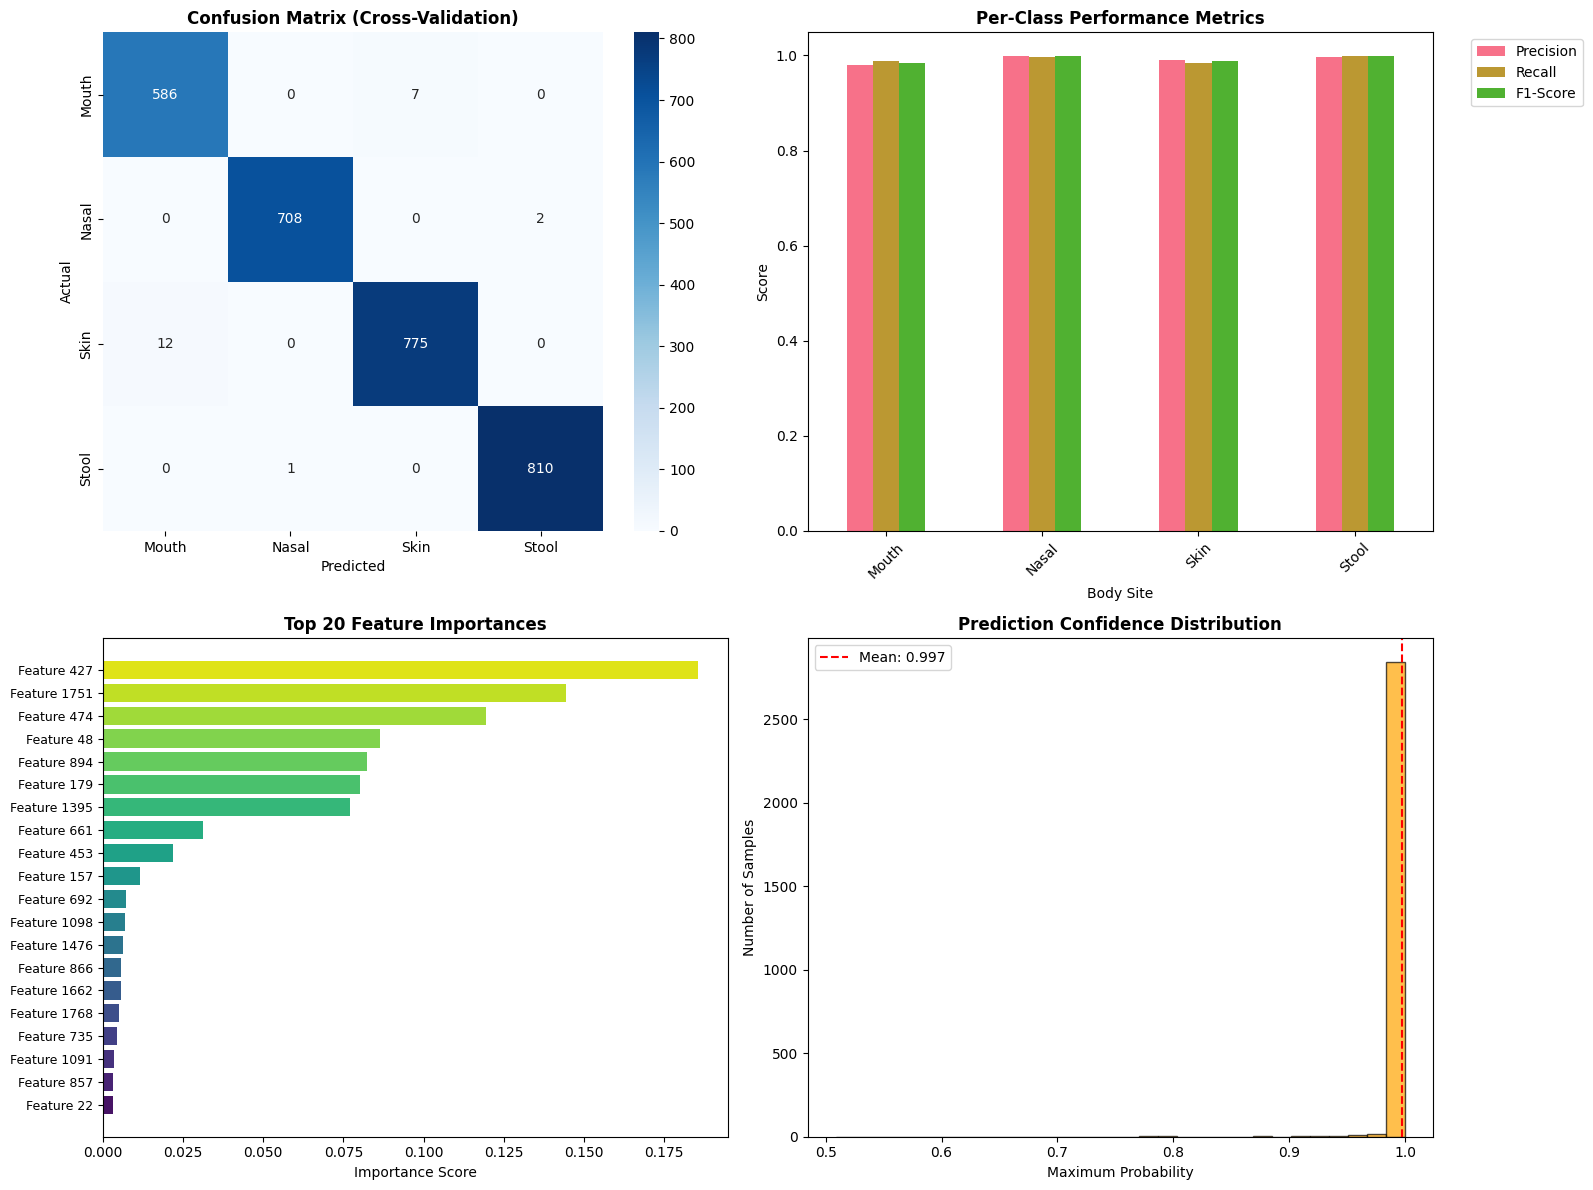

🎯 Model Performance Summary:
   Overall Accuracy: 0.9924
   Mean Confidence: 0.997
   Per-class F1 scores:
     Mouth: 0.9840
     Nasal: 0.9979
     Skin: 0.9879
     Stool: 0.9982


In [34]:
# 4. Model Performance Analysis
print("🎯 Generating cross-validation predictions for detailed analysis...")

# Get CV predictions for confusion matrix
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
cv_predictions = np.zeros(len(y_encoded))
cv_probabilities = np.zeros((len(y_encoded), len(class_names)))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y_encoded)):
    X_train_fold, X_val_fold = X_selected[train_idx], X_selected[val_idx]
    y_train_fold, y_val_fold = y_encoded[train_idx], y_encoded[val_idx]
    
    # Train model on fold
    fold_model = xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        random_state=RANDOM_STATE, n_jobs=N_JOBS
    )
    fold_model.fit(X_train_fold, y_train_fold)
    
    # Predict on validation set
    cv_predictions[val_idx] = fold_model.predict(X_val_fold)
    cv_probabilities[val_idx] = fold_model.predict_proba(X_val_fold)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
cm = confusion_matrix(y_encoded, cv_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title('Confusion Matrix (Cross-Validation)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Classification metrics per class
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(y_encoded, cv_predictions, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=class_names)

metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=ax2)
ax2.set_title('Per-Class Performance Metrics', fontsize=12, fontweight='bold')
ax2.set_xlabel('Body Site')
ax2.set_ylabel('Score')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

# Feature importance (top 20)
feature_importance = final_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:]
top_features_importance = feature_importance[top_features_idx]

ax3.barh(range(len(top_features_importance)), top_features_importance, 
         color=sns.color_palette("viridis", len(top_features_importance)))
ax3.set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
ax3.set_xlabel('Importance Score')
ax3.set_yticks(range(len(top_features_importance)))
ax3.set_yticklabels([f"Feature {i}" for i in top_features_idx], fontsize=9)

# Prediction confidence distribution
max_probs = cv_probabilities.max(axis=1)
ax4.hist(max_probs, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax4.set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Maximum Probability')
ax4.set_ylabel('Number of Samples')
ax4.axvline(max_probs.mean(), color='red', linestyle='--', 
            label=f'Mean: {max_probs.mean():.3f}')
ax4.legend()

plt.tight_layout()
plt.savefig('microbiome_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"🎯 Model Performance Summary:")
print(f"   Overall Accuracy: {(cv_predictions == y_encoded).mean():.4f}")
print(f"   Mean Confidence: {max_probs.mean():.3f}")
print(f"   Per-class F1 scores:")
for i, (class_name, f1_score) in enumerate(zip(class_names, f1)):
    print(f"     {class_name}: {f1_score:.4f}")

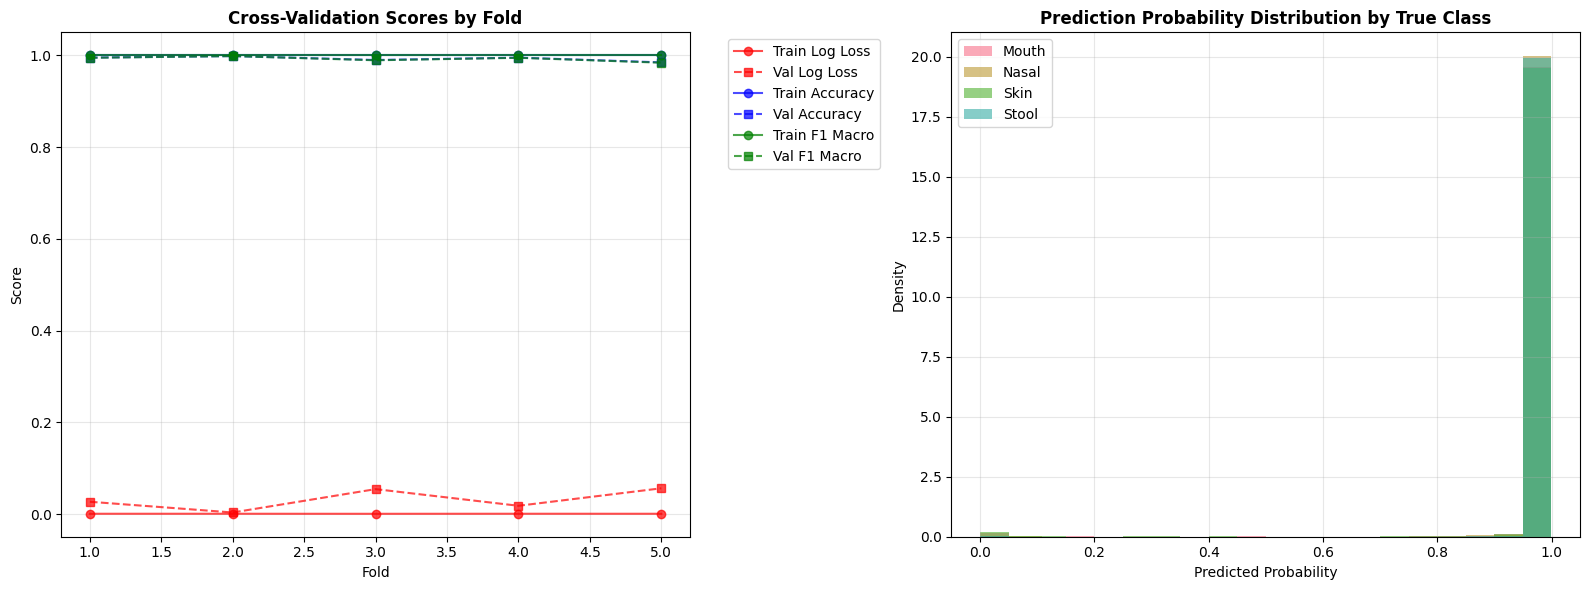

📊 Cross-Validation Stability:
   Log Loss CV std: 0.0206
   Accuracy CV std: 0.0048
   F1-Score CV std: 0.0050


In [35]:
# 5. Cross-Validation Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# CV scores across folds
cv_scores_detailed = cross_validate(
    final_model, X_selected, y_encoded, cv=skf, 
    scoring=['neg_log_loss', 'accuracy', 'f1_macro'], 
    return_train_score=True
)

metrics = ['neg_log_loss', 'accuracy', 'f1_macro']
colors = ['red', 'blue', 'green']

for i, metric in enumerate(metrics):
    train_scores = cv_scores_detailed[f'train_{metric}']
    test_scores = cv_scores_detailed[f'test_{metric}']
    
    if metric == 'neg_log_loss':
        train_scores = -train_scores  # Convert to positive log loss
        test_scores = -test_scores
        metric_name = 'Log Loss'
    else:
        metric_name = metric.replace('_', ' ').title()
    
    folds = range(1, len(train_scores) + 1)
    ax1.plot(folds, train_scores, 'o-', color=colors[i], alpha=0.7, 
             label=f'Train {metric_name}')
    ax1.plot(folds, test_scores, 's--', color=colors[i], alpha=0.7, 
             label=f'Val {metric_name}')

ax1.set_title('Cross-Validation Scores by Fold', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Score')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Prediction distribution by class
for i, class_name in enumerate(class_names):
    class_mask = y_encoded == i
    class_probs = cv_probabilities[class_mask, i]
    ax2.hist(class_probs, bins=20, alpha=0.6, label=class_name, density=True)

ax2.set_title('Prediction Probability Distribution by True Class', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('microbiome_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Cross-Validation Stability:")
print(f"   Log Loss CV std: {cv_scores['test_neg_log_loss'].std():.4f}")
print(f"   Accuracy CV std: {cv_scores['test_accuracy'].std():.4f}")
print(f"   F1-Score CV std: {cv_scores['test_f1_macro'].std():.4f}")

In [36]:
print("🎨 Visualization Summary:")
print("=" * 50)
print("Generated visualizations:")
print("1. 📊 microbiome_sample_distribution.png - Class balance analysis")
print("2. 🧬 microbiome_kmer_diversity.png - K-mer abundance and sparsity") 
print("3. 🔍 microbiome_dimensionality_reduction.png - PCA and t-SNE plots")
print("4. 🎯 microbiome_model_performance.png - Confusion matrix and metrics")
print("5. 📈 microbiome_learning_curves.png - CV stability analysis")
print("=" * 50)
print("✅ All visualizations completed!")

🎨 Visualization Summary:
Generated visualizations:
1. 📊 microbiome_sample_distribution.png - Class balance analysis
2. 🧬 microbiome_kmer_diversity.png - K-mer abundance and sparsity
3. 🔍 microbiome_dimensionality_reduction.png - PCA and t-SNE plots
4. 🎯 microbiome_model_performance.png - Confusion matrix and metrics
5. 📈 microbiome_learning_curves.png - CV stability analysis
✅ All visualizations completed!
